# Direction of Arrival using Spectrum Estimators: Array Processing

**Implemented by:**  
**Lakshitha Ramanayake** and **M. Hamza Rafi**

---

## Overview

This guide walks you through how different spectrum estimators can be applied to find the **Direction of Arrival (DOA)** in array processing.

- **Objective:** To demonstrate how spectrum estimators can effectively identify the DOA in various scenarios.

---


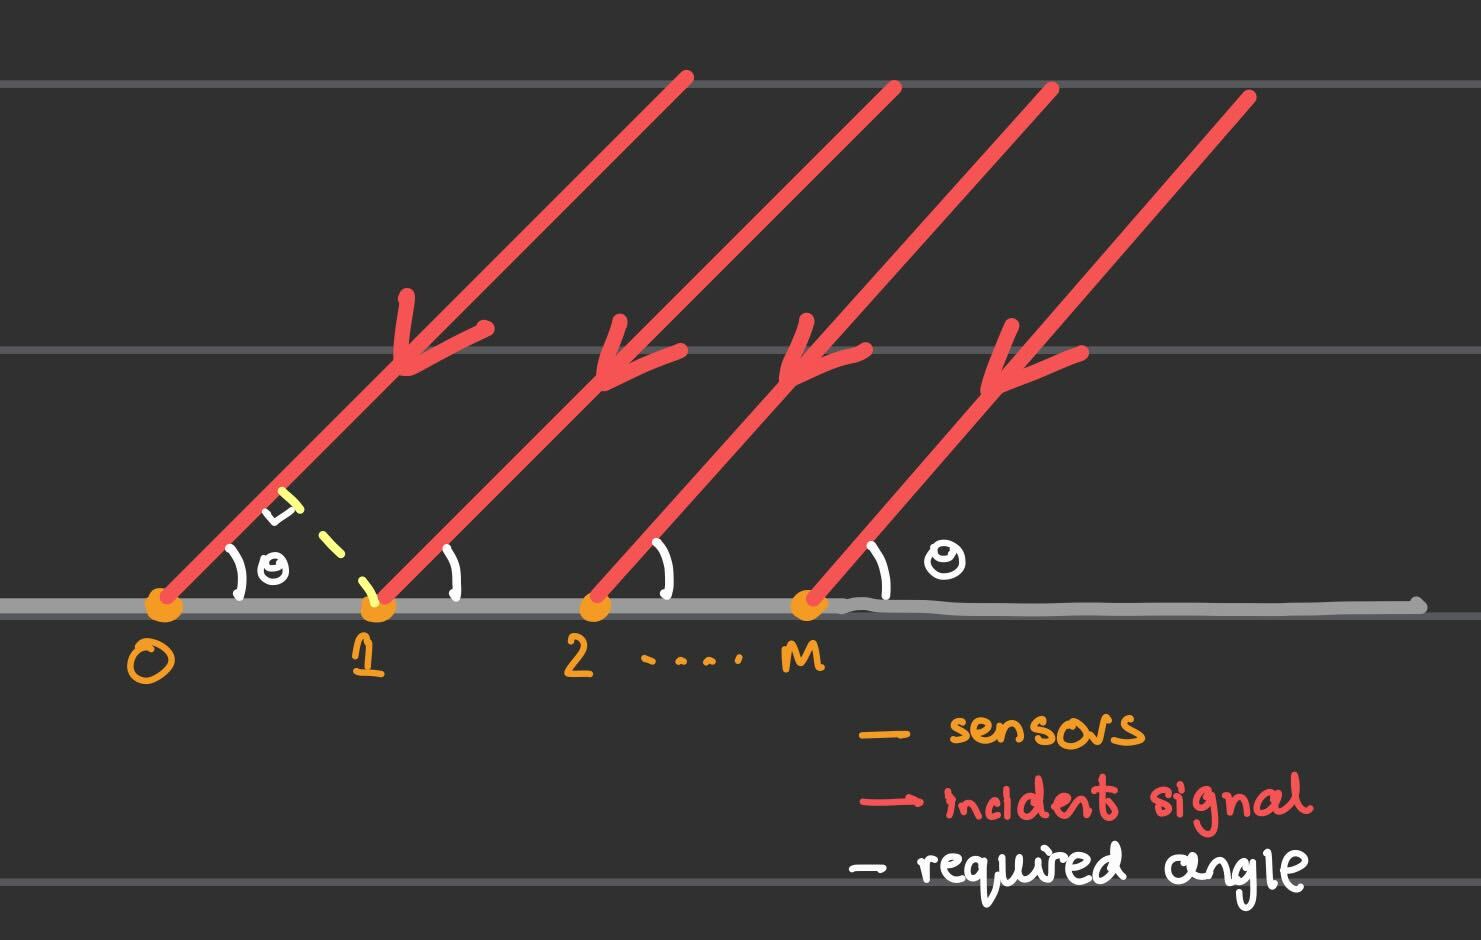

##### Importing the necessary libraries

In [55]:
#data loading and manupilations
import scipy
import pandas as pd
import numpy as np

#system 
import platform

#plotting 
import matplotlib.pyplot as plt
import seaborn as sns

#peak finder
from scipy.signal import find_peaks

##### Loading Data files

In [56]:
# Load the .mat file

if platform.system() == 'Windows':
    mat_file_path = r"D:\Fall 2024\Optimum Signal Processing\Project\submarine.mat"  # Use raw string (r'...') to avoid escaping issues
elif platform.system() == 'Darwin':
    mat_file_path = '/Users/lakrama/Academic/Fall 2024/Optimum Signal Processing/EE525-Optimum-Signal-Processing-Find-the-Sub/submarine.mat'
else:
    raise OSError("Unsupported operating system.")

RAW_DICT= scipy.io.loadmat(mat_file_path)

In [57]:
#assigning variables 

array_signals = RAW_DICT['X']
wavelength  =  RAW_DICT['lambda']
distance  = RAW_DICT ['d']

print('The shape of the signal array:',array_signals.shape)
print('The wavelength of the signal:', wavelength)
print('The distance between the array elements',distance)

The shape of the signal array: (6, 4096)
The wavelength of the signal: [[5.32]]
The distance between the array elements [[0.9]]


#### Estimiating the covariance matrix

1.  This is the spatial covariance matrix of signals received by the array elements. 
2.  This can be estimated using all the signal samples that we have.
3.  The next option is to calculate the covariance matrix for a window of  time instances 

<div align="center">
   R(n)  where n = n,....., n + l
</div>

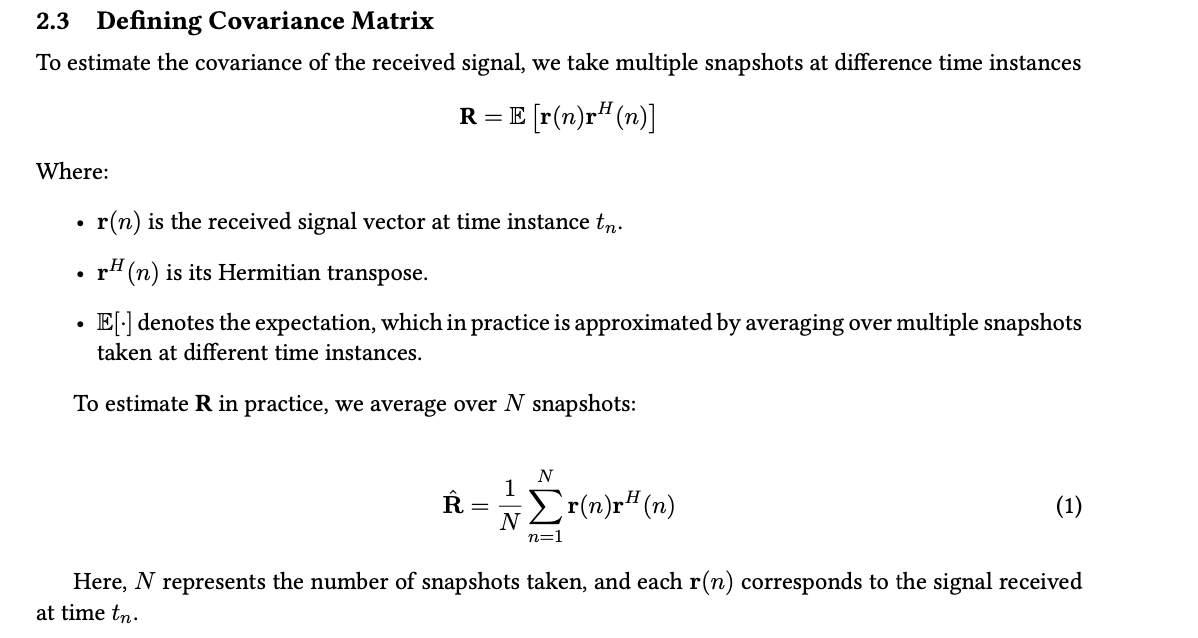

In [58]:
#this the estimate of the covariance matrix
covariance_estimate = (array_signals @ array_signals.conj().T) / array_signals.shape[1]
print('Estimate of Covairance Matrix')

#In case we want to compute the covarince matrix at time instance n using a window of l length 

def covariance_at_time_n(n,l,signal_array):
    if n and n+l  <= signal_array.shape[1]:
        array_window = signal_array[:,n:n+l]
        covariance = (array_window @ array_window.conj().T )
    else:
        print('time index out of range.') 
    return covariance

def decoded_angle(phi,wavelength,distance):
    angle = (phi*wavelength) / (2*np.pi*distance)
    theta = np.arcsin(angle)
    return np.degrees(theta)



Estimate of Covairance Matrix


#### Defining the steering vectors and angle range to test over

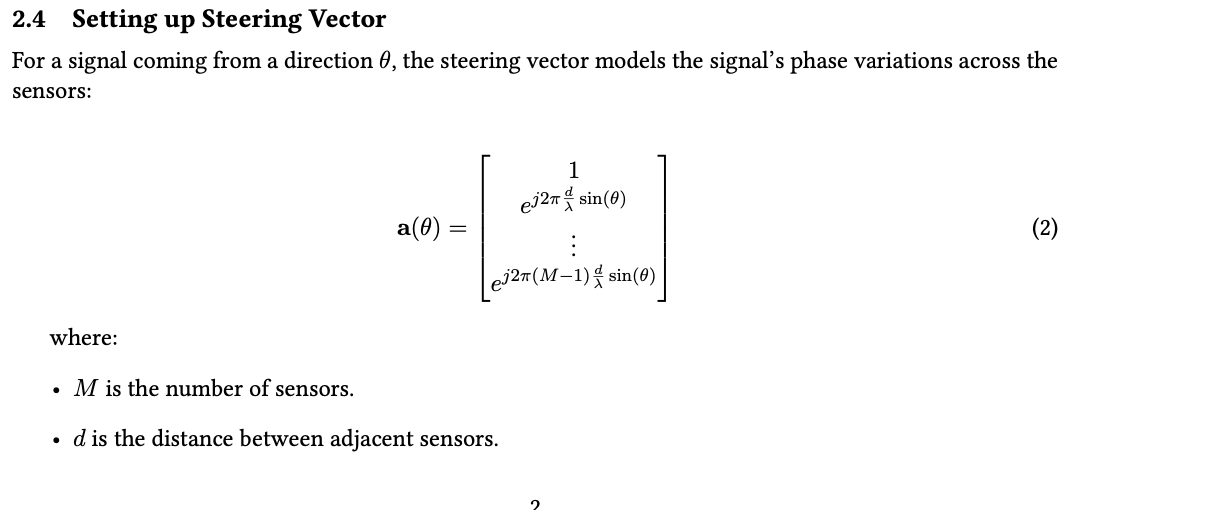
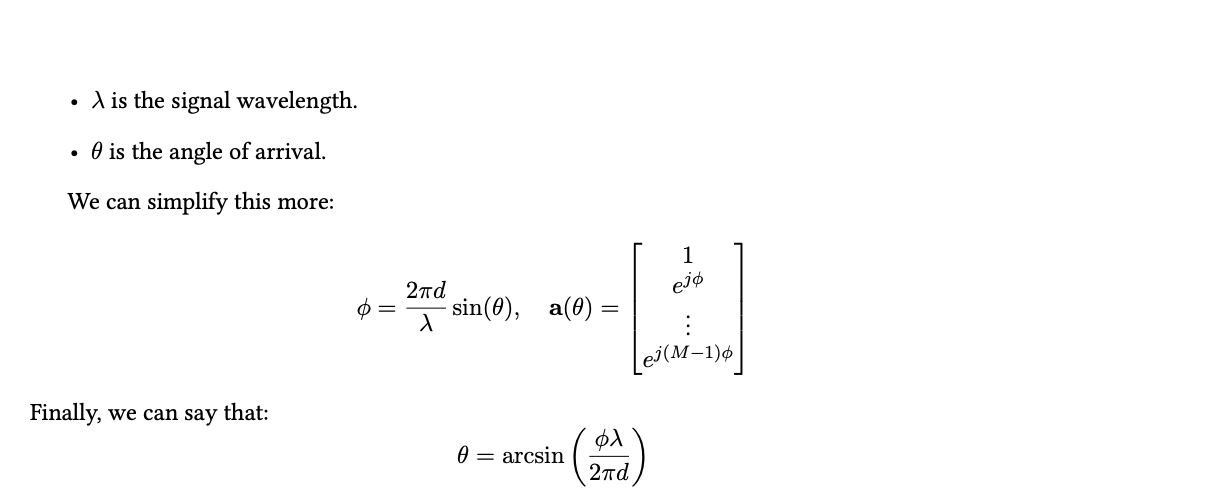

In [108]:
def steeringvector(length,angle):
    #column vector with the indices 
    indices = np.arange(length).reshape((length,1))
    steering_vec = np.exp(-1j * angle * indices)
    return steering_vec

def generate_theta_range(L):
    theta_range = np.array([-np.pi/2 + (np.pi / L) * k for k in range(L)])
    return theta_range

#### The function to find the peaks of the function

In [109]:
def find_peak_angle(spectrum, theta_range,method):
    # Convert the spectrum to a NumPy array (if not already)
    spectrum = np.array(spectrum)
    
    # Find all peaks in the spectrum
    peaks, _ = find_peaks(spectrum)

    # Check how many peaks are found
    num_peaks = len(peaks)
    print('')    
    print(f'Method: {method}')
    print('---------------------------------------------------------------------')
    
    
    if num_peaks == 0:
        raise ValueError("No peaks found in the spectrum")
    else:
        # Get the values of the peaks
        peak_values = spectrum[peaks]
        print(f"Number of peaks found: {num_peaks}")
        print("Peak values:", peak_values)

        # Get the indices of the peaks in the original signal
        peak_angles = theta_range[peaks]
        # Print the indices and their values
        print('')
        print("Indices of the peaks:", peaks)
        print("Values of the peaks:", spectrum[peaks])
        print("steering angle of the peaks (in degrees):", np.degrees(peak_angles))
        print("direction of arrival (in degrees):",np.array([decoded_angle(phi,wavelength,distance) for phi in peak_angles]).flatten())
        print('---------------------------------------------------------------------')
        print('')
        print('')

## Subspace Methods 
---

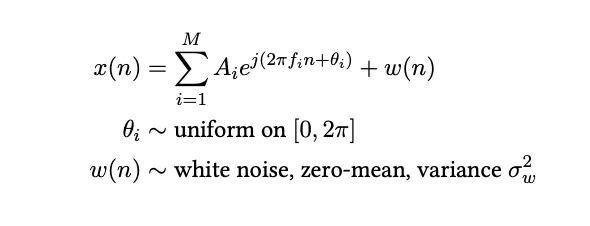


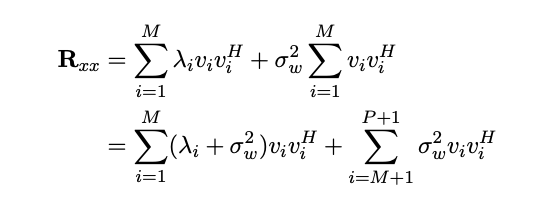

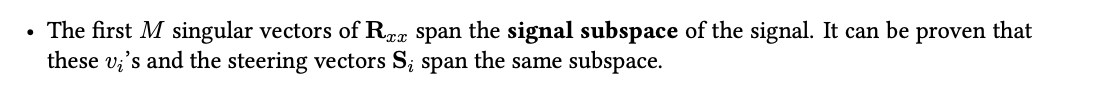

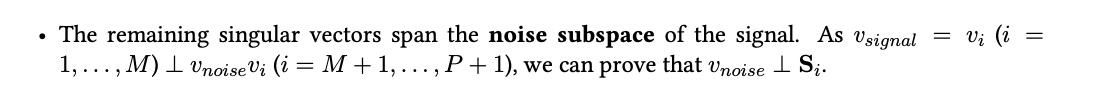

SVD is applied to the covariance matrix of the received signal data in an array. It decomposes this matrix into three components: 

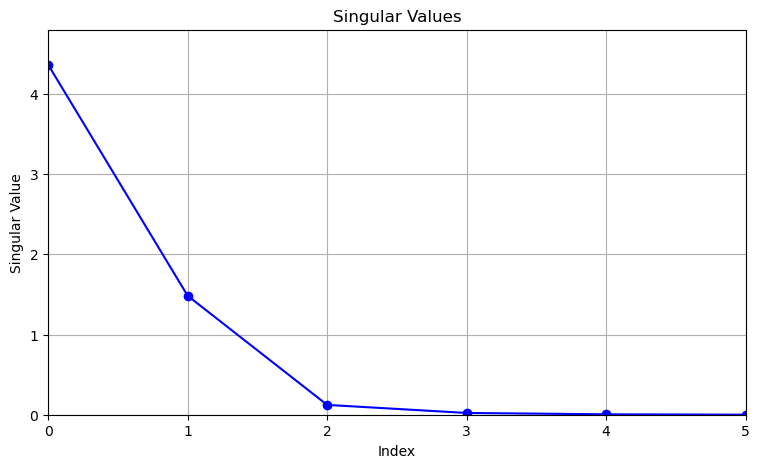

In [110]:
# first we start by perfoming singular value decomposition on the covariance matrix 

# Assuming U is the matrix of left singular vectors obtained from SVD
U, s, VT = np.linalg.svd(covariance_estimate)

#plotting the singular values of the matrix 
# Step 3: Plot the singular values
plt.figure(figsize=(9, 5))
plt.plot(s, marker='o', linestyle='-', color='b')
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid()
plt.xticks(np.arange(len(s)))  # Set x-ticks to match the indices of singular values
plt.xlim(0, len(s) - 1)  # Set x-limits
plt.ylim(0, np.max(s) * 1.1)  # Add a little space above the max singular value
plt.show()



*   Looking at this we can identify the separation between the signal and noise sub-spaces.
*   Ideally the noise subspace corresponding singular vectors should have constant singular values.
*   It seems the signal and noise subspace separation might be at eigen value #2 or #3. (remember the indexing starts from 0)

#### 1. Music Method

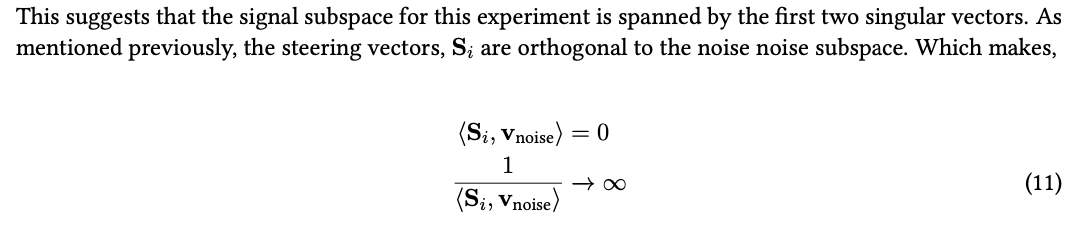

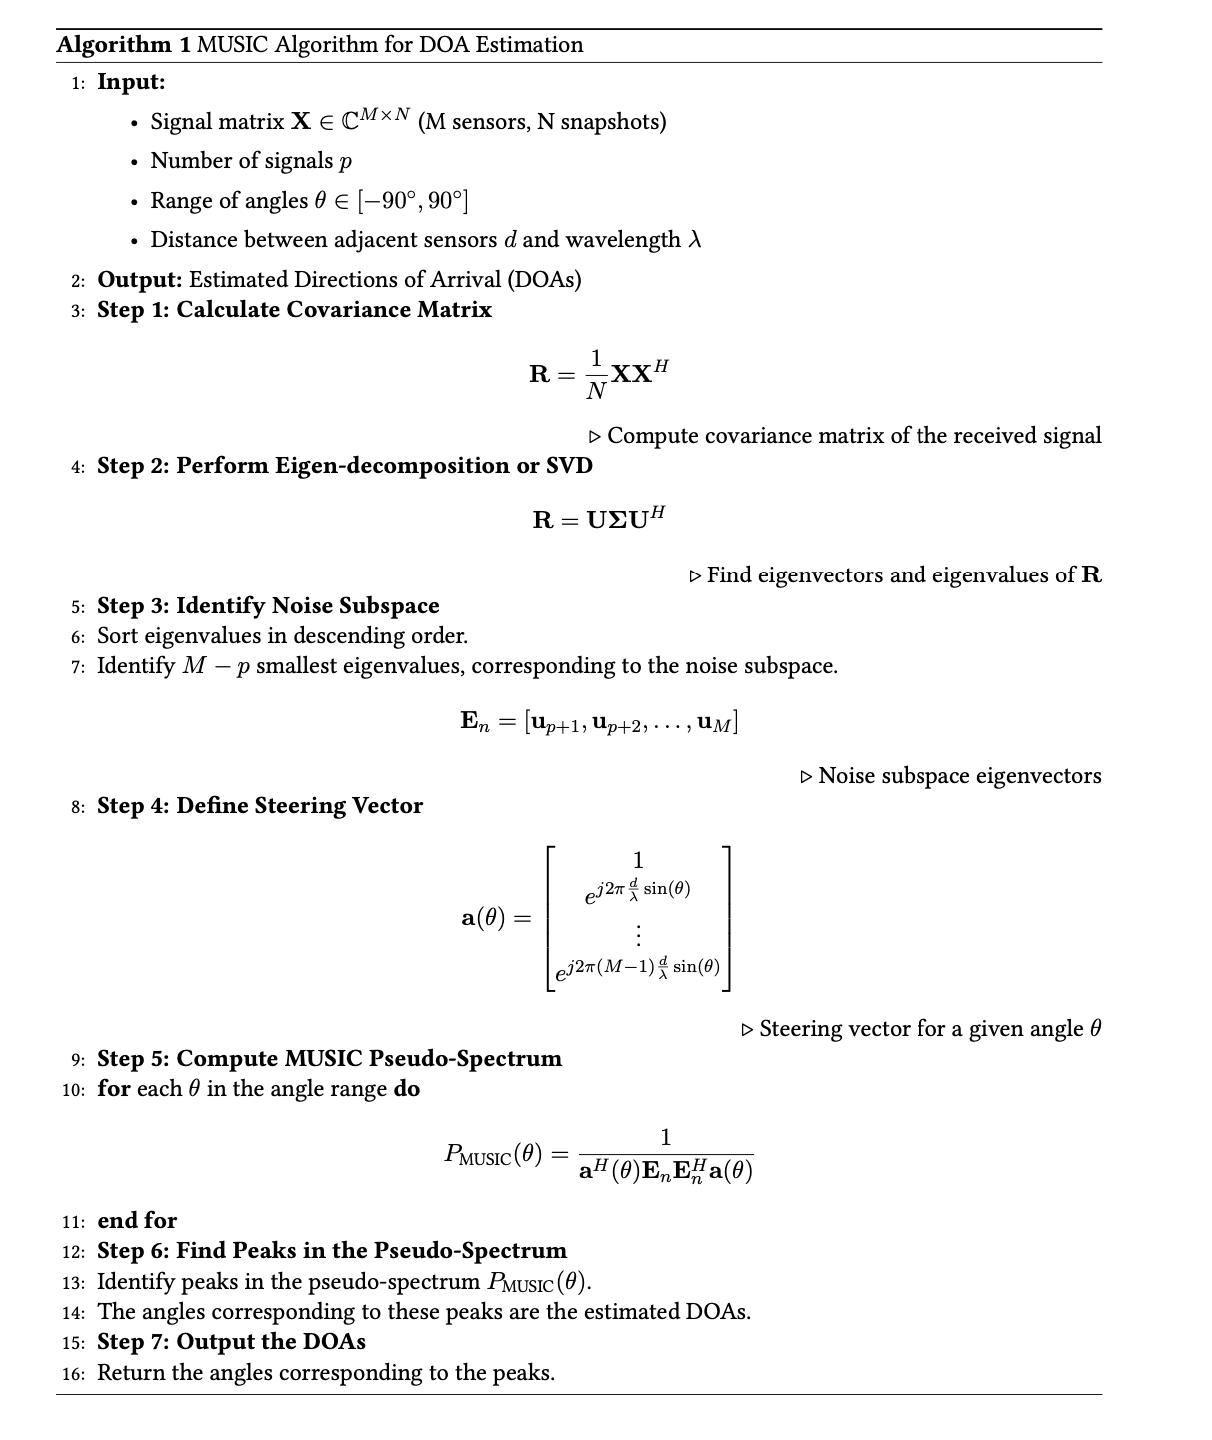

In [111]:
#music method function 

def music_spectrum(noise_subspace,theta_range,length):
    spectrum = []
    for theta in theta_range:
        a = steeringvector(length,theta)
        spectrum.append((1 / np.abs(a.conj().T @ noise_subspace @ noise_subspace.conj().T @ a)).item())
    return spectrum

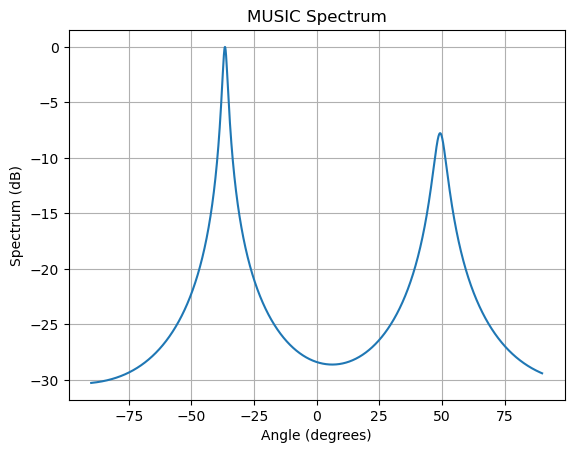

In [112]:
# Deciding eigen values
margin = 2

#signal subspace corresponding eigen vecotors
signal_subspace = U[:,:margin]
#noise subspace corresponding eigen vectors
noise_subspace = U[:,margin:]

#generating the theta range 
theta_range = generate_theta_range(array_signals.shape[1])
spectrum = music_spectrum(noise_subspace,theta_range,6)


plt.plot(np.degrees(theta_range).tolist(), 10 * np.log10(spectrum / np.max(spectrum)))  # Normalize and plot in dB
plt.xlabel('Angle (degrees)')
plt.ylabel('Spectrum (dB)')
plt.title('MUSIC Spectrum')
plt.grid(True)
plt.show()

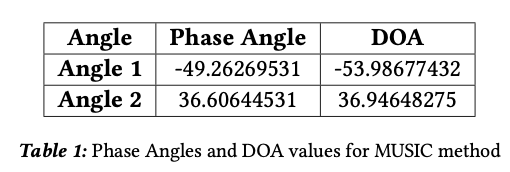

Let's plot the spectrum as a function of theta

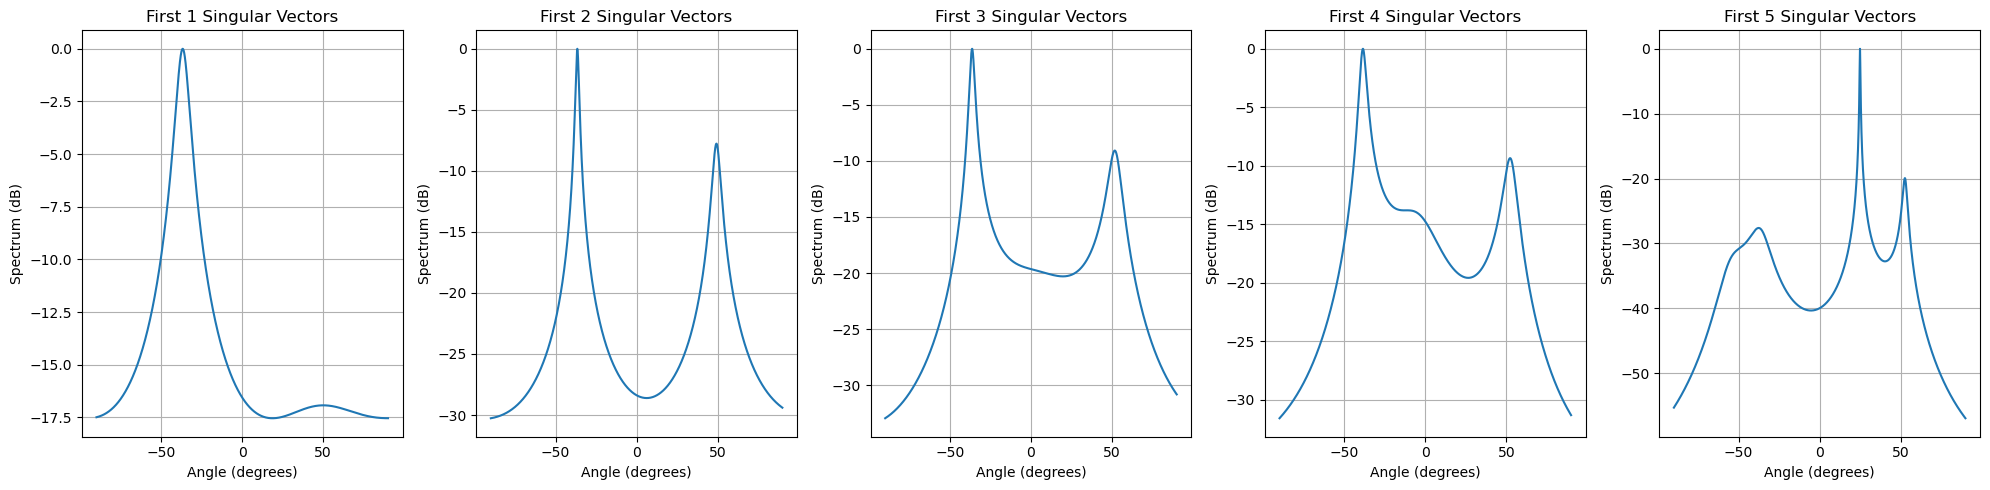

In [113]:
# Assuming generate_theta_range and music_spectrum are predefined

# Iterating over margin values from 1 to 5
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

all_spectrums = []

for margin in range(1, 6):
    # Signal subspace corresponding eigen vectors
    signal_subspace = U[:, :margin]
    # Noise subspace corresponding eigen vectors
    noise_subspace = U[:, margin:]

    # Generating the theta range
    theta_range = generate_theta_range(array_signals.shape[1])
    
    # Calculating the MUSIC spectrum
    spectrum = music_spectrum(noise_subspace, theta_range, 6)

    all_spectrums.append(spectrum)

    # Plot the result in the corresponding subplot
    axes[margin - 1].plot(np.degrees(theta_range).tolist(), 10 * np.log10(spectrum / np.max(spectrum)))  # Normalize and plot in dB
    axes[margin - 1].set_xlabel('Angle (degrees)')
    axes[margin - 1].set_ylabel('Spectrum (dB)')
    axes[margin - 1].set_title(f'First {margin} Singular Vectors')
    axes[margin - 1].grid(True)

# Adjust layout for readability
plt.tight_layout()
plt.show()


Let's find the peaks and decode the angles.

In [114]:
iter = 0
for spectrum in all_spectrums:
    iter = iter + 1
    method = f'Music method with signal sub-space spanned by {iter} signular vectors'
    find_peak_angle(spectrum, theta_range,method)


Method: Music method with signal sub-space spanned by 1 signular vectors
---------------------------------------------------------------------
Number of peaks found: 2
Peak values: [9.46443291 0.19196452]

Indices of the peaks: [1211 3185]
Values of the peaks: [9.46443291 0.19196452]
steering angle of the peaks (in degrees): [-36.78222656  49.96582031]
direction of arrival (in degrees): [-37.15368752  55.12750407]
---------------------------------------------------------------------



Method: Music method with signal sub-space spanned by 2 signular vectors
---------------------------------------------------------------------
Number of peaks found: 2
Peak values: [184.37751318  30.82630083]

Indices of the peaks: [1215 3169]
Values of the peaks: [184.37751318  30.82630083]
steering angle of the peaks (in degrees): [-36.60644531  49.26269531]
direction of arrival (in degrees): [-36.94648275  53.98677432]
---------------------------------------------------------------------



Method: M

#### 2. Pisarenko's  Method 

1.  In Pisarenko's method we assume that the noise subspace is spanned by the last singular value of the auto-correlation matrix.
2.  And we know that the steering vectors/the signal subspace is orthoganal to the noise subspace.

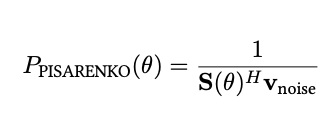

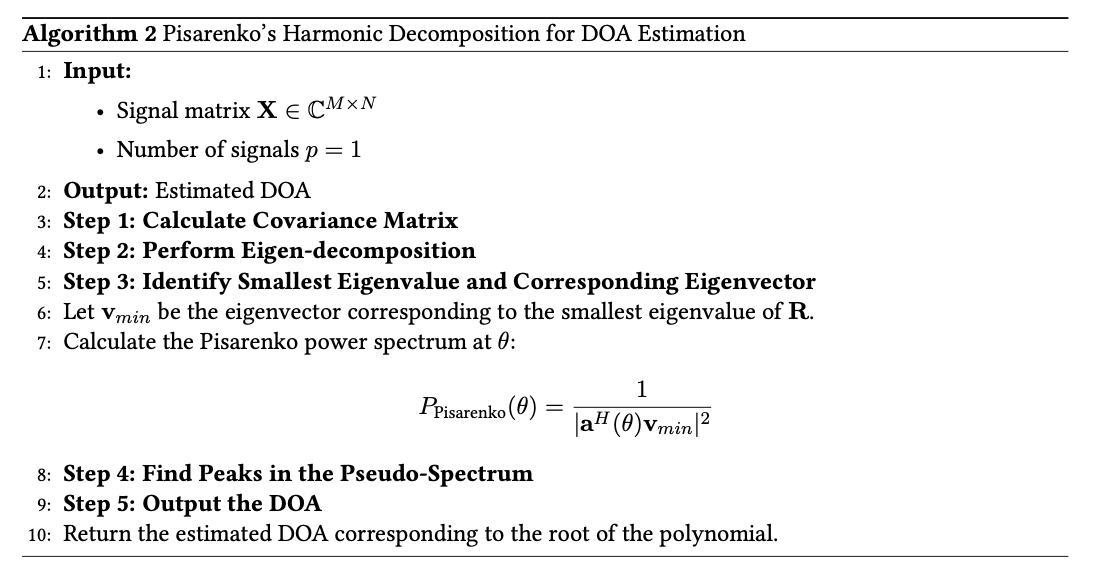

In [115]:
def pisarenko_spectrum(singular_vectors, theta_range,length):
  
    # Smallest eigenvector corresponds to the noise subspace
    v = singular_vectors[:,-1] 

    # Compute the Pisarenko spectrum
    spectrum = []
    for theta in theta_range:
        a = steeringvector(length,theta)
        power = (1 / np.abs(a.conj().T @ v) ** 2).item()  # Pisarenko spectrum formula
        spectrum.append(power)

    return np.array(spectrum)


#generating the theta range 
theta_range = generate_theta_range(array_signals.shape[1])
#run the function for the pisarenko's spectrum
pisarenko_spec = pisarenko_spectrum(U,theta_range,6)

Plotting the Pisarenko's spectrum

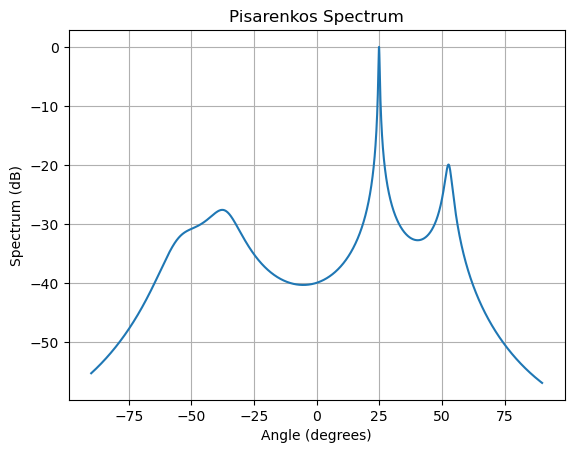

In [116]:
plt.plot(np.degrees(theta_range).tolist(), 10 * np.log10(pisarenko_spec / np.max(pisarenko_spec)))  # Normalize and plot in dB
plt.xlabel('Angle (degrees)')
plt.ylabel('Spectrum (dB)')
plt.title('Pisarenkos Spectrum')
plt.grid(True)
plt.show()

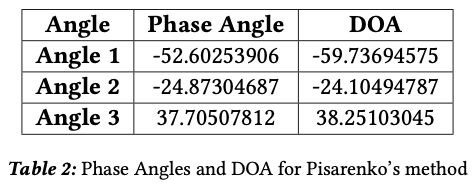

Important remark: If we set the last signular vector of the auto correlation matrix to span the noise subspace in the music method you will endup with the Pisarenko method.

Let's try to find the peaks and the direction of arrival,

In [117]:
method = f'Pisarenkos Method'
find_peak_angle(pisarenko_spec, theta_range,method)


Method: Pisarenkos Method
---------------------------------------------------------------------
Number of peaks found: 3
Peak values: [  1459.27352857 843461.16521961   8556.3805109 ]

Indices of the peaks: [1190 2614 3245]
Values of the peaks: [  1459.27352857 843461.16521961   8556.3805109 ]
steering angle of the peaks (in degrees): [-37.70507812  24.87304687  52.60253906]
direction of arrival (in degrees): [-38.25103045  24.10494787  59.73694575]
---------------------------------------------------------------------




## Minimum Variance Estimate 

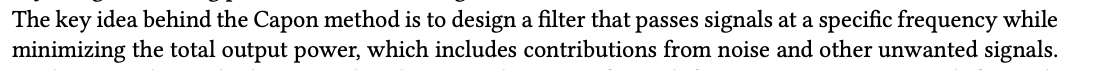

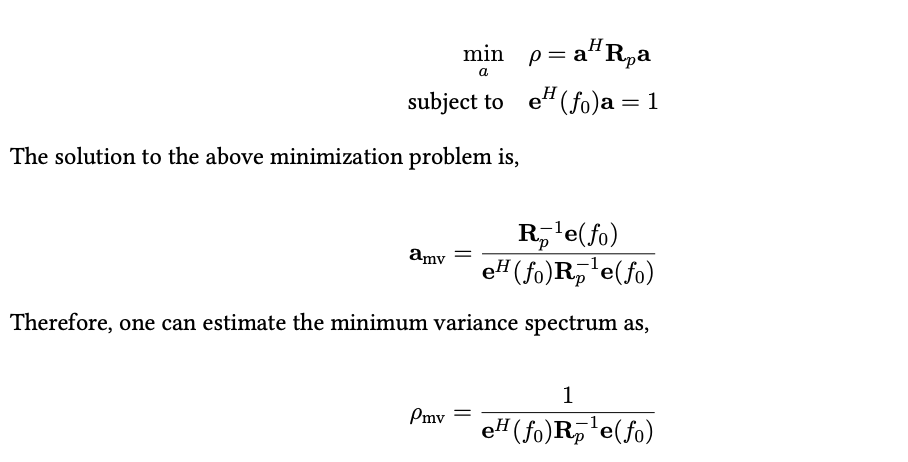

1. Here we are computing the correlation matrix using all the samples we have.

In [131]:
def mv_spectrum(covariance_estimate,theta_range,length):

    spectrum = []
    covariance_estimate_inv = np.linalg.inv(covariance_estimate)  # Inverse of the covariance matrix

    for theta in theta_range:
        a_theta = steeringvector(length,theta)  # Steering vector for theta
        power = 1 / (a_theta.conj().T @ covariance_estimate_inv @ a_theta)  # MVDR power estimate
        spectrum.append(power)

    return np.array(spectrum).flatten()  # Ensure it is a 1D array


#generating the theta range 
theta_range = generate_theta_range(array_signals.shape[1])
#run the function for the pisarenko's spectrum
MV_spec = mv_spectrum(covariance_estimate,theta_range,6)
MV_spec = np.abs(MV_spec)

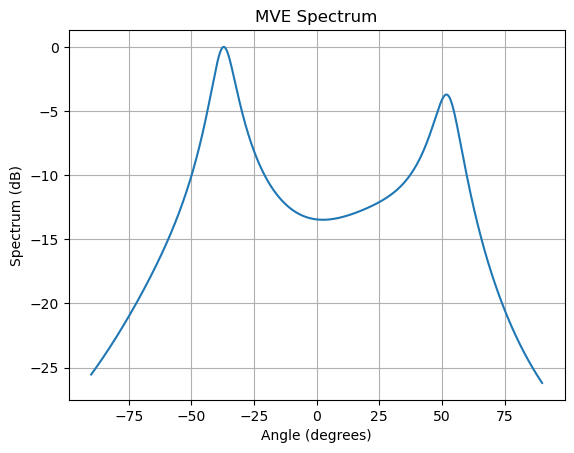

In [132]:
# plotting 
plt.plot(np.degrees(theta_range).tolist(), 10 * np.log10(MV_spec / np.max(MV_spec)))  # Normalize and plot in dB
plt.xlabel('Angle (degrees)')
plt.ylabel('Spectrum (dB)')
plt.title('MVE Spectrum')
plt.grid(True)
plt.show()

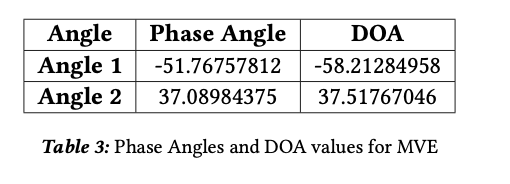

Let's identify the peaks and the angles of arrivals,

In [133]:
method = f'Minimum Variance Method'
find_peak_angle(MV_spec, theta_range,method)


Method: Minimum Variance Method
---------------------------------------------------------------------
Number of peaks found: 2
Peak values: [0.36960343 0.15720851]

Indices of the peaks: [1204 3226]
Values of the peaks: [0.36960343 0.15720851]
steering angle of the peaks (in degrees): [-37.08984375  51.76757812]
direction of arrival (in degrees): [-37.51767046  58.21284958]
---------------------------------------------------------------------




- Now let's try to take a window from the signals and estimate the covariance matrix form that window. 
- We are starting the window from 200th time instance. 
- We are changing the window size to be [10,100,1000,2000,3000]

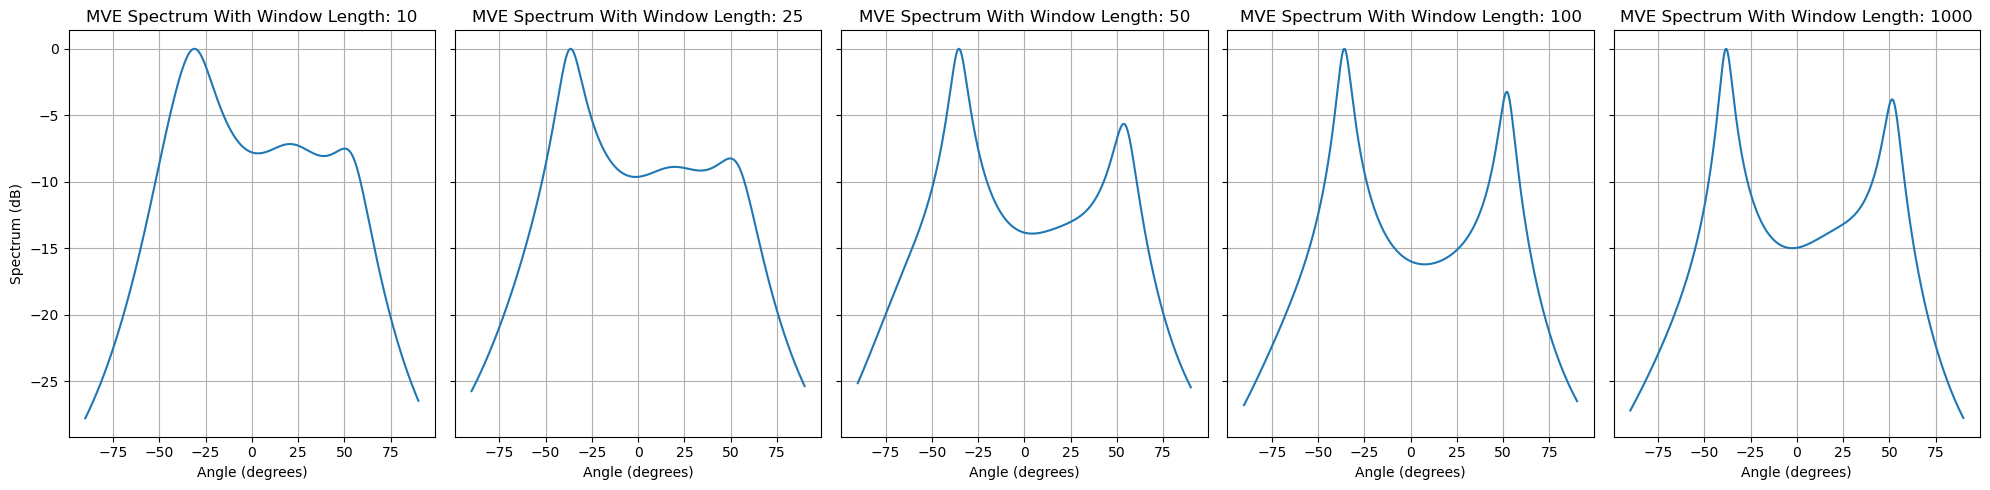

In [134]:
# Define the different window lengths
window_lengths = [10, 25, 50, 100,1000]
starting_time = 1

mv_all_spectrums = []  # List to store all spectra

# Generate theta range (in radians)
theta_range = generate_theta_range(array_signals.shape[1])

# Create the subplots
fig, axs = plt.subplots(1, len(window_lengths), figsize=(20, 5), sharey=True)  

for i, window_length in enumerate(window_lengths):
    # Compute covariance matrix for the current window length
    less_sample_cov = covariance_at_time_n(starting_time, window_length, array_signals)
    
    # Compute MUSIC spectrum
    MV_spec = mv_spectrum(less_sample_cov, theta_range, 6)
    MV_spec = np.abs(MV_spec)  # Ensure it's positive
    
    # Normalize and convert to dB
    MV_spec_dB = 10 * np.log10(MV_spec / np.max(MV_spec))
    
    # Append the spectrum to the list
    mv_all_spectrums.append(MV_spec)
    
    # Plot the spectrum on the current subplot
    axs[i].plot(np.degrees(theta_range), MV_spec_dB)
    axs[i].set_title(f'MVE Spectrum With Window Length: {window_length}')
    axs[i].set_xlabel('Angle (degrees)')
    axs[i].grid(True)

# Set common y-label
axs[0].set_ylabel('Spectrum (dB)')

# Adjust layout to avoid overlapping text
plt.tight_layout()

# Show the plot
plt.show()

Finding peaks of the spectrum and estimating the angle of arraivals,

In [135]:
for count,spectrum in enumerate (mv_all_spectrums):
    method = f'MV spectrum with covirance matrix estimated through {window_lengths[count]} samples'
    find_peak_angle(spectrum, theta_range,method)



Method: MV spectrum with covirance matrix estimated through 10 samples
---------------------------------------------------------------------
Number of peaks found: 3
Peak values: [0.00065586 0.00012615 0.00011656]

Indices of the peaks: [1341 2516 3189]
Values of the peaks: [0.00065586 0.00012615 0.00011656]
steering angle of the peaks (in degrees): [-31.06933594  20.56640625  50.14160156]
direction of arrival (in degrees): [-30.67387662  19.73652211  55.41779768]
---------------------------------------------------------------------



Method: MV spectrum with covirance matrix estimated through 25 samples
---------------------------------------------------------------------
Number of peaks found: 3
Peak values: [0.06089176 0.00788565 0.00912471]

Indices of the peaks: [1218 2499 3179]
Values of the peaks: [0.06089176 0.00788565 0.00912471]
steering angle of the peaks (in degrees): [-36.47460938  19.81933594  49.70214844]
direction of arrival (in degrees): [-36.7914484   18.99154375  5

### MVE using the low rank approximation of the sample covariance matix

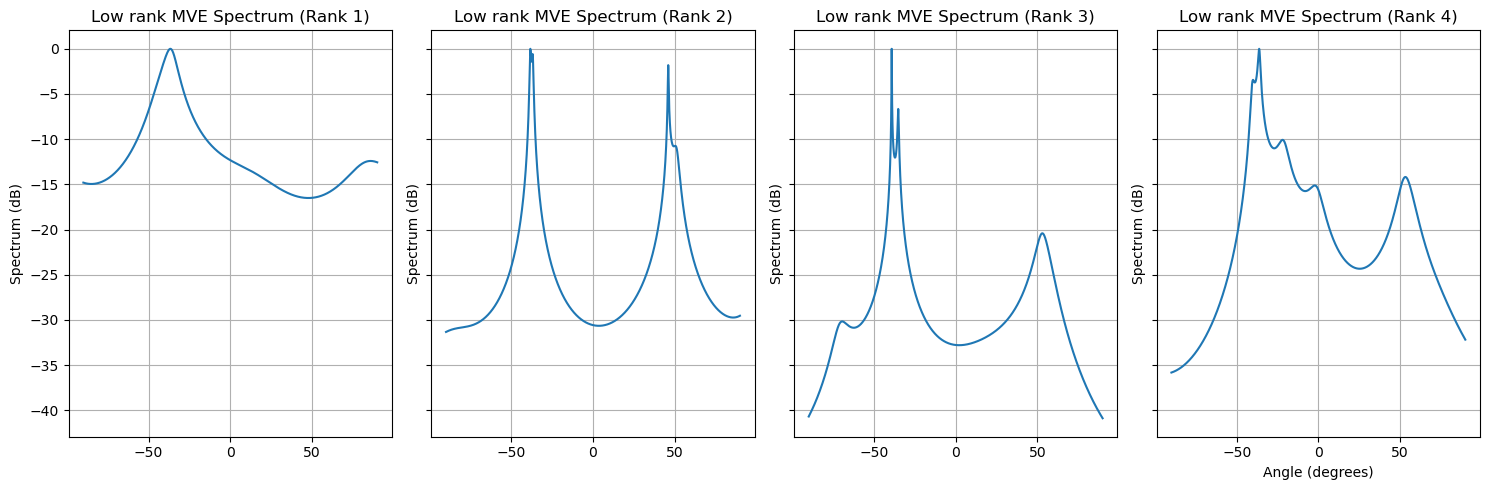

In [136]:
#function to perform low rank estimation

def low_rank_approximation(U, S, Vh, k):
    
    # Take the first k singular values and vectors
    U_k = U[:, :k]               # First k columns of U
    S_k = np.diag(S[:k])         # Top k singular values as a diagonal matrix
    Vh_k = Vh[:k, :]             # First k rows of Vh

    # Compute the low-rank approximation
    X_k = U_k @ S_k @ Vh_k

    return X_k




lr_mv_all_spectrums = []
ranks = range(1, 5)

# Create a figure with one row of multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=len(ranks), figsize=(15, 5), sharey=True)

for i, rank in enumerate(ranks):
    # Perform low-rank approximation
    rank_estimate_of_cov = low_rank_approximation(U, s, VT, rank)

    # Generate the theta range
    theta_range = generate_theta_range(array_signals.shape[1])

    # Compute the MUSIC spectrum
    MV_spec_less = mv_spectrum(rank_estimate_of_cov, theta_range, 6)
    MV_spec_less = np.abs(MV_spec_less)
    lr_mv_all_spectrums.append(MV_spec_less)

    # Plot the spectrum on the corresponding subplot
    axes[i].plot(np.degrees(theta_range).tolist(), 
                 10 * np.log10(MV_spec_less / np.max(MV_spec_less)))  # Normalize and plot in dB

    # Set labels and grid for each subplot
    axes[i].set_ylabel('Spectrum (dB)')
    axes[i].grid(True)
    axes[i].set_title(f'Low rank MVE Spectrum (Rank {rank})')

# Set xlabel for the bottom subplot
axes[-1].set_xlabel('Angle (degrees)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [137]:
for count,spectrum in enumerate (lr_mv_all_spectrums):
    method = f'MV spectrum with rank {ranks[count]} estimation of covirance matrix'
    find_peak_angle(spectrum, theta_range,method)


Method: MV spectrum with rank 1 estimation of covirance matrix
---------------------------------------------------------------------
Number of peaks found: 2
Peak values: [7.09025816e-16 4.06982454e-17]

Indices of the peaks: [1213 4002]
Values of the peaks: [7.09025816e-16 4.06982454e-17]
steering angle of the peaks (in degrees): [-36.69433594  85.86914062]
direction of arrival (in degrees): [-37.05001442          nan]
---------------------------------------------------------------------



Method: MV spectrum with rank 2 estimation of covirance matrix
---------------------------------------------------------------------
Number of peaks found: 4
Peak values: [9.66457328e-14 8.45807935e-14 6.37300633e-14 8.15263152e-15]

Indices of the peaks: [1175 1206 3096 3195]
Values of the peaks: [9.66457328e-14 8.45807935e-14 6.37300633e-14 8.15263152e-15]
steering angle of the peaks (in degrees): [-38.36425781 -37.00195312  46.0546875   50.40527344]
direction of arrival (in degrees): [-39.04507

/var/folders/r8/5wc8dngx7j55w_gyx0q8q2x80000gn/T/ipykernel_4168/3556715303.py:17: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(angle)


## Periodogram

We estimate the power spectral density of the received signals by computing the Fourier Transform of the spatial correlation matrix

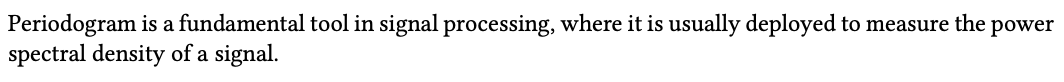
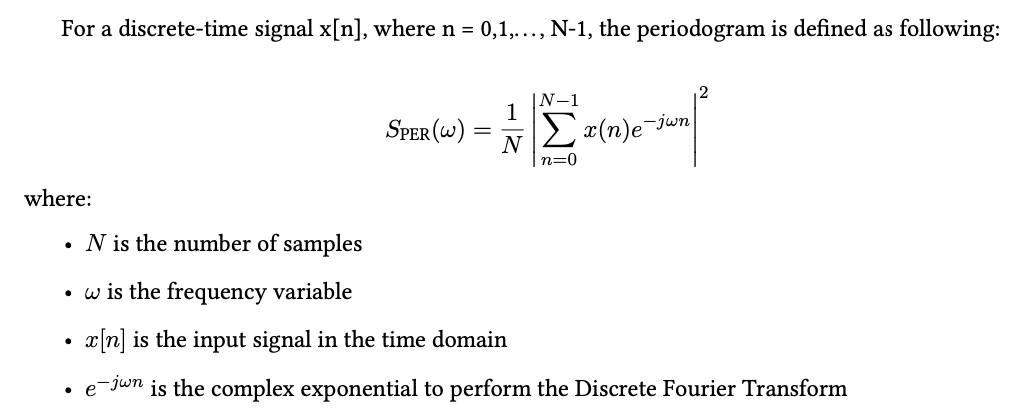

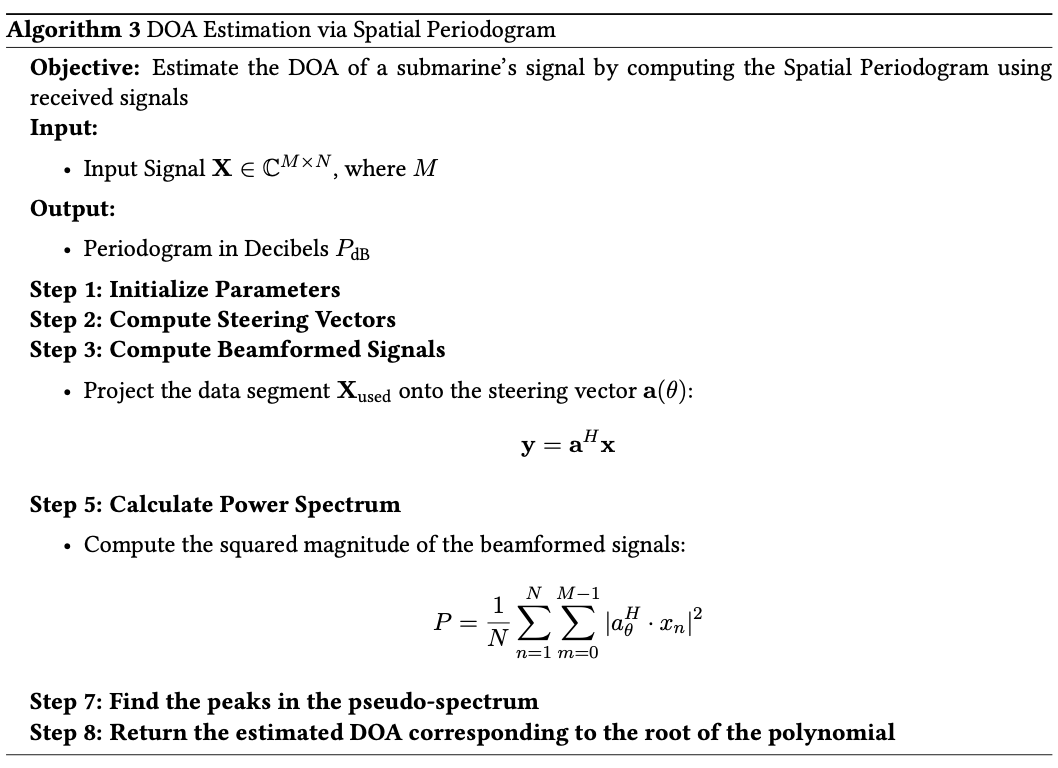

In [125]:
def compute_spatial_periodogram(input_signal, window_length, wavelength=wavelength):

    sensor_num, total_samples = input_signal.shape

    # Use only the first 'window_length' samples from the input signal
    data_used = input_signal[:, 0:window_length]

    # Generating steering vector for all the angles
    theta_range = generate_theta_range(total_samples)  # Total_samples remains the same

    # Initialize periodogram array
    P = np.zeros(len(theta_range), dtype=float)

    # Get steering vectors
    steering_vectors = steeringvector(sensor_num, theta_range)


    # Compute the periodogram
    y = steering_vectors.conj().T @ data_used
    P = np.mean(np.abs(y)**2, axis=1)

    # Normalize the periodogram
    P_normalized = P / np.max(P)

    # Convert to decibel scale
    P_dB = 10 * np.log10(P_normalized + 1e-12)  # Add epsilon to avoid log(0)

    # Convert theta_range to degrees for plotting
    theta_degrees = np.degrees(theta_range)

    return [P_dB, theta_degrees]


Peak in the periodogram correspond to the direction of arrival of the signals representing the location of the sources (ie. submarine in our case)

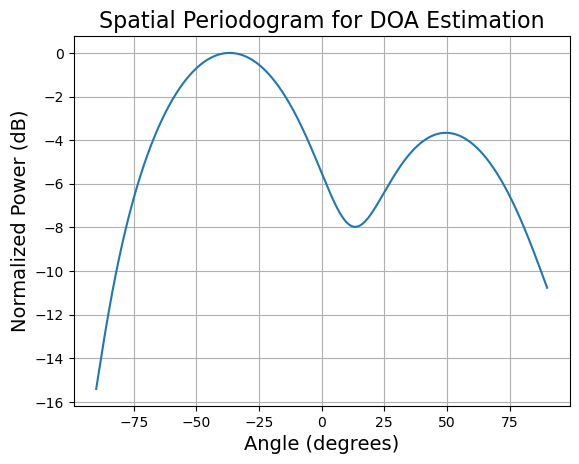

In [126]:
#Computing periodogram for the complete signal
P_db_complete, theta_degrees_complete = compute_spatial_periodogram(array_signals,array_signals.shape[1])

#Plotting
plt.plot(theta_degrees_complete, P_db_complete)  # Normalize and plot in dB
plt.title('Spatial Periodogram for DOA Estimation', fontsize=16)
plt.xlabel('Angle (degrees)', fontsize=14)
plt.ylabel('Normalized Power (dB)', fontsize=14)
plt.grid(True)
plt.show()

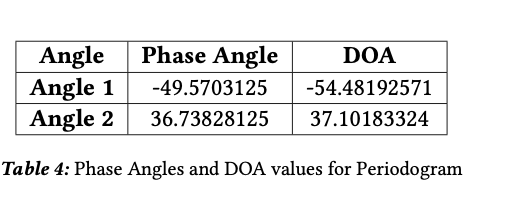

Identifying the peaks and the angles of arrivals 

In [127]:
method = f'Periodogram'
find_peak_angle(P_db_complete, theta_range,method)


Method: Periodogram
---------------------------------------------------------------------
Number of peaks found: 2
Peak values: [ 4.34333091e-12 -3.66362831e+00]

Indices of the peaks: [1212 3176]
Values of the peaks: [ 4.34333091e-12 -3.66362831e+00]
steering angle of the peaks (in degrees): [-36.73828125  49.5703125 ]
direction of arrival (in degrees): [-37.10183324  54.48192571]
---------------------------------------------------------------------




In order to evaluate the changes on the output periodogram, let's vary the window length of the input data 

In [128]:
theta_range = generate_theta_range(array_signals.shape[1])
P_dB = []
theta_degrees = []

window_lengths = [250,500,1000,1500,4096]
for elements in window_lengths: 
    P_db_temp,theta_degrees_temp = compute_spatial_periodogram(array_signals,elements)
    P_dB.append(P_db_temp)
    theta_degrees.append(theta_degrees_temp)

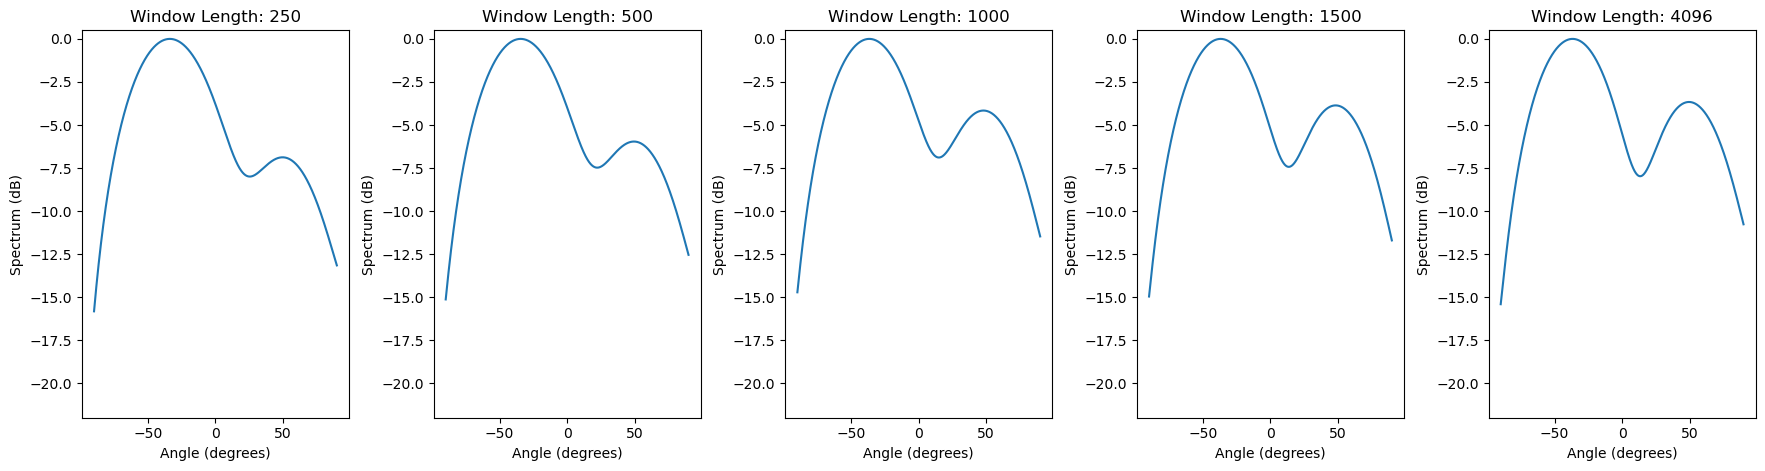

In [129]:
# Labels for the subplots (can be window lengths or any other identifier)
labels = []
for elements in window_lengths:
    labels.append(str(elements))

# Create subplots, 1 row, multiple columns (for each window length)
fig, axs = plt.subplots(1, len(P_dB), figsize=(18, 5))  # Adjust the size as needed
fig.tight_layout(pad=3.0)

# Plot each P_dB against the corresponding theta_degrees
for i in range(len(P_dB)):
    axs[i].plot(theta_degrees[i], P_dB[i])
    axs[i].set_title(f"Window Length: {labels[i]}")
    axs[i].set_xlabel("Angle (degrees)")
    axs[i].set_ylabel("Spectrum (dB)")
    axs[i].set_ylim([-22, 0.5])  # Adjust the limits based on your data range

# Display the plot
plt.show()

In [130]:
for count,spectrum in enumerate (P_dB):
    method = f'Spatial Periodogram estimated through {window_lengths[count]} samples'
    find_peak_angle(spectrum,theta_range,method)


Method: Spatial Periodogram estimated through 250 samples
---------------------------------------------------------------------
Number of peaks found: 2
Peak values: [ 4.34333091e-12 -6.87680231e+00]

Indices of the peaks: [1278 3179]
Values of the peaks: [ 4.34333091e-12 -6.87680231e+00]
steering angle of the peaks (in degrees): [-33.83789062  49.70214844]
direction of arrival (in degrees): [-33.75272719  54.69597613]
---------------------------------------------------------------------



Method: Spatial Periodogram estimated through 500 samples
---------------------------------------------------------------------
Number of peaks found: 2
Peak values: [ 4.34333091e-12 -5.96130317e+00]

Indices of the peaks: [1263 3175]
Values of the peaks: [ 4.34333091e-12 -5.96130317e+00]
steering angle of the peaks (in degrees): [-34.49707031  49.52636719]
direction of arrival (in degrees): [-34.50188686  54.41082425]
---------------------------------------------------------------------



Method: